#### 👀 카테고리 필터링 후 추천 구현 후

## 구글 드라이브 연결 및 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 8.7 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt

## Training Data 불러오기

In [ ]:
# CSV 파일 경로 지정
csv_file_path = '/content/drive/MyDrive/인지프/특허Dataset/Training_csv/csv_merge.csv'

# CSV 파일 불러오기
df = pd.read_csv(csv_file_path)

# 데이터프레임을 확인
df

<ipython-input-4-848df92341a4>:5: DtypeWarning: Columns (0,2,5,6,7,9,10,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


,country_code,updateDate,Mtext,documentId,application_number,Lno,Ltext,keyword,ipc_main,document_type,...,abstract,ipc_subclass,applicant_name,register_year,ipc_all,ipc_class,claims,application_date,register_number,open_year
0,KR,20230525.0,정밀생산기계,kr20000000442b1,2000-0000442,EA,기계,IT/기계·제조,B21D-028/02,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KR,20230525.0,정밀생산기계,kr20000000993b1,2000-0000993,EA,기계,IT/기계·제조,B23Q-017/00,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KR,20230525.0,정밀생산기계,kr20000001378a,2000-0001378,EA,기계,IT/기계·제조,B26D-003/00,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KR,20230525.0,정밀생산기계,kr20000001481b1,2000-0001481,EA,기계,IT/기계·제조,B24B-003/34,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KR,20230525.0,정밀생산기계,kr20000005614b1,2000-0005614,EA,기계,IT/기계·제조,H01L-021/302,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240186,NaN,NaN,NaN,kr20220087865b1,2022-0087865,NaN,NaN,NaN,B01J-020/02,NaN,...,본 발명은 천연광물인 루미라이트를 이용한 오염된 자연 수역의 하천 호소 생태 복원제...,B01J,박기호,2022.0,B01J-020/02|B01J-020/30|C02F-001/28|C02F-001/5...,B01,"규산(SiO2) 67∼68중량%, 알루미늄(Al203)11∼14중량%, 산화철(Fe...",20220716.0,2438279.0,NaN
240187,NaN,NaN,NaN,kr20227011040a,2022-7011040,NaN,NaN,NaN,C08F-261/06,NaN,...,"본 발명은 광물 결합제용 분산제로서 분지형 공중합체의 사용에 관한 것이되, 공중합체...",C08F,시카 테크놀러지 아게,NaN,C08F-261/06|C04B-024/26|C04B-028/02|C08F-216/1...,C08,"광물 결합제용 분산제로서 공중합체의 용도로서, 상기 공중합체는 다음으로 형성되는, ...",20201125.0,NaN,NaN
240188,NaN,NaN,NaN,kr20227011041a,2022-7011041,NaN,NaN,NaN,C04B-024/32,NaN,...,본 발명은 광물 결합제 조성물 유속을 증가시키고 그리고 점도를 감소시키기 위한 첨가...,C04B,시카 테크놀러지 아게,NaN,C04B-024/32|C04B-024/26|C04B-028/02|C04B-040/0...,C04,광물 결합제 조성물의 유속을 증가시키고/시키거나 점도를 감소시키기 위한 첨가제로서의...,20201125.0,NaN,NaN
240189,NaN,NaN,NaN,kr20227018709a,2022-7018709,NaN,NaN,NaN,C04B-020/02,NaN,...,본 발명은 기계화학적으로 카르복실화된 광물 충전재 및 결합재를 포함하는 조성물에 관...,C04B,카본 업사이클링 테크놀러지스 인코포레이티드,NaN,C04B-020/02|C04B-018/08|C04B-020/00|C04B-024/2...,C04,기계화학적으로 카르복실화된 광물 충전재 및 결합재를 포함하는 조성물로서; 결합재는 ...,20201104.0,NaN,NaN


In [ ]:
original_df = df # 데이터 복원을 위한 저장
# df = original_df

# 샘플 데이터 (IPC_SECTION이 C인 행들만)

In [ ]:
count_D_rows = len(df[df['ipc_section'] == 'D'])
count_D_rows

4555

In [ ]:
# 'ipc_section' 열 값이 'C'인 행만 남기기
filtered_df = df[df['ipc_section'] == 'D']

# 인덱스 재정렬
filtered_df = filtered_df.reset_index(drop=True)

In [ ]:
filtered_df

,country_code,updateDate,Mtext,documentId,application_number,Lno,Ltext,keyword,ipc_main,document_type,...,abstract,ipc_subclass,applicant_name,register_year,ipc_all,ipc_class,claims,application_date,register_number,open_year
0,NaN,NaN,NaN,jp2007237709b2,2007-237709,NaN,NaN,NaN,D06M-015/263,NaN,...,"(과제) 에너지 절약형이며, 실온으로 또한 간편한 조작으로 안전하게, 합성 섬유를 ...",D06M,독립행정법인 산업기술총합 연구소,2012.0,D06M-015/263|D06M-014/32|D06M-015/00|D06M-010/...,D06,광조사에 의해 래디컬을 발생하는 과산화물과 전자 흡인성기가 직접 탄소-탄소 이중 결...,20070913.0,5152713.0,2009.0
1,NaN,NaN,NaN,kr20020010803a,2002-0010803,NaN,NaN,NaN,D04H-003/00,NaN,...,"본 발명은, 맹암거용 부직포 및 그 제조방법에 관한 것으로서, 하중을 견딜 수 있는...",D04H,도레이첨단소재 주식회사,NaN,D04H-003/00,D04,폴리에스테르 수지 필라멘트를 다공질 벨트상에 구성섬유의 섬도가 2∼8데니어가 되도록...,20020228.0,NaN,2003.0
2,NaN,NaN,NaN,kr20167020657b1,2016-7020657,NaN,NaN,NaN,D06N-005/00,NaN,...,본 발명은 역청을 함침시키는 단계가 뒤따르는 섬유 매트(4)의 양면 중 적어도 한 ...,D06N,온두린,2021.0,D06N-005/00|E04D-003/34|E04D-005/02,D06,"섬유 매트(4)의 양면 중 적어도 한 면을 코팅하는 단계와, 뒤이어 역청을 함침시키...",20150122.0,2335757.0,NaN
3,NaN,NaN,NaN,kr20050042996b1,2005-0042996,NaN,NaN,NaN,D06F-039/08,NaN,...,본 발명은 드럼세탁기에서 수위감지센서의 오작동을 방지하여 히터의 과열을 방지하는 드...,D06F,엘지전자 주식회사,2013.0,D06F-039/08|G01F-023/00,D06,"물을 저장하기 위한 케이스;상기 케이스에 고정되는 리셉터클 하우징과, 상기 리셉터클...",20050523.0,1253126.0,2006.0
4,NaN,NaN,NaN,kr20177014908b1,2017-7014908,NaN,NaN,NaN,D01D-005/04,NaN,...,본 발명은 탄성섬유 건식 방사 소자 및 방사 부품에 관한 것이다. 상기 방사 소자는...,D01D,정저우 중위안 스판덱스 엔지니어링 테크놀로지 컴퍼니 리미티드,2018.0,D01D-005/04|D01D-001/09|D01D-004/00,D01,종 방향으로 복수 개의 서로 이격된 고분자 용액 통로가 설치되는 하우징을 포함하는 ...,20141204.0,1934380.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,NaN,NaN,NaN,kr20160045212a,2016-0045212,NaN,NaN,NaN,D06M-011/00,NaN,...,본 발명은 직물에 도포하여 코팅된 광물질을 카본발열체(B)의 열로 효능이 증가되게 ...,D06M,박영근,NaN,D06M-011/00|D06B-001/02|D06B-015/00|D06M-011/4...,D06,광물질을 카본발열체(B)의 발열기능을 통해 효능을 증가시키는 직물발열체(A)에 있어...,20160413.0,NaN,2016.0
4551,NaN,NaN,NaN,kr20170032009b1,2017-0032009,NaN,NaN,NaN,D03D-015/00,NaN,...,"본 발명은 인체의 보온과 땀 흡수, 배출 기능 그리고 겉옷의 착용상태를 보조하는 등...",D03D,김완종|김호진,2017.0,D03D-015/00|D01F-001/10|D02G-001/02|D02G-003/30,D03,"소취율이 높은 내의 원단은,맥반석, 현무암, 운석류 및 제올라이트를 포함하는 광물질...",20170314.0,1778981.0,NaN
4552,NaN,NaN,NaN,kr20177020985a,2017-7020985,NaN,NaN,NaN,D04H-001/58,NaN,...,"본 발명은 적어도 1개의 컨베이어 벨트(20A, 20B)와 함께 이동하는 광물 및/...",D04H,쌩-고벵 이조베르,NaN,D04H-001/58|B29C-067/24|D04H-001/4218|D04H-001...,D04,"컨베이어 벨트(20A, 20B)를 갖는 적어도 1개의 컨베이어(18A, 18B)에 ...",20151221.0,NaN,2017.0
4553,NaN,NaN,NaN,kr20180166126b1,2018-0166126,NaN,NaN,NaN,D06P-001/34,NaN,...,"본 발명의 일 실시예에 따른 섬유 생산 방법은, (a) 실이 염색 탱크에 장착되는 ...",D06P,박노정,2020.0,D06P-001/34|D06B-015/00|D06B-019/00|D06B-003/0...,D06,(a) 실이 염색 탱크에 장착되는 단계;(b) 물 및 화산석 입자가 혼합되어 화산석...,20181220.0,2173802.0,NaN


In [ ]:
df = filtered_df
df

,country_code,updateDate,Mtext,documentId,application_number,Lno,Ltext,keyword,ipc_main,document_type,...,abstract,ipc_subclass,applicant_name,register_year,ipc_all,ipc_class,claims,application_date,register_number,open_year
0,NaN,NaN,NaN,jp2007237709b2,2007-237709,NaN,NaN,NaN,D06M-015/263,NaN,...,"(과제) 에너지 절약형이며, 실온으로 또한 간편한 조작으로 안전하게, 합성 섬유를 ...",D06M,독립행정법인 산업기술총합 연구소,2012.0,D06M-015/263|D06M-014/32|D06M-015/00|D06M-010/...,D06,광조사에 의해 래디컬을 발생하는 과산화물과 전자 흡인성기가 직접 탄소-탄소 이중 결...,20070913.0,5152713.0,2009.0
1,NaN,NaN,NaN,kr20020010803a,2002-0010803,NaN,NaN,NaN,D04H-003/00,NaN,...,"본 발명은, 맹암거용 부직포 및 그 제조방법에 관한 것으로서, 하중을 견딜 수 있는...",D04H,도레이첨단소재 주식회사,NaN,D04H-003/00,D04,폴리에스테르 수지 필라멘트를 다공질 벨트상에 구성섬유의 섬도가 2∼8데니어가 되도록...,20020228.0,NaN,2003.0
2,NaN,NaN,NaN,kr20167020657b1,2016-7020657,NaN,NaN,NaN,D06N-005/00,NaN,...,본 발명은 역청을 함침시키는 단계가 뒤따르는 섬유 매트(4)의 양면 중 적어도 한 ...,D06N,온두린,2021.0,D06N-005/00|E04D-003/34|E04D-005/02,D06,"섬유 매트(4)의 양면 중 적어도 한 면을 코팅하는 단계와, 뒤이어 역청을 함침시키...",20150122.0,2335757.0,NaN
3,NaN,NaN,NaN,kr20050042996b1,2005-0042996,NaN,NaN,NaN,D06F-039/08,NaN,...,본 발명은 드럼세탁기에서 수위감지센서의 오작동을 방지하여 히터의 과열을 방지하는 드...,D06F,엘지전자 주식회사,2013.0,D06F-039/08|G01F-023/00,D06,"물을 저장하기 위한 케이스;상기 케이스에 고정되는 리셉터클 하우징과, 상기 리셉터클...",20050523.0,1253126.0,2006.0
4,NaN,NaN,NaN,kr20177014908b1,2017-7014908,NaN,NaN,NaN,D01D-005/04,NaN,...,본 발명은 탄성섬유 건식 방사 소자 및 방사 부품에 관한 것이다. 상기 방사 소자는...,D01D,정저우 중위안 스판덱스 엔지니어링 테크놀로지 컴퍼니 리미티드,2018.0,D01D-005/04|D01D-001/09|D01D-004/00,D01,종 방향으로 복수 개의 서로 이격된 고분자 용액 통로가 설치되는 하우징을 포함하는 ...,20141204.0,1934380.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,NaN,NaN,NaN,kr20160045212a,2016-0045212,NaN,NaN,NaN,D06M-011/00,NaN,...,본 발명은 직물에 도포하여 코팅된 광물질을 카본발열체(B)의 열로 효능이 증가되게 ...,D06M,박영근,NaN,D06M-011/00|D06B-001/02|D06B-015/00|D06M-011/4...,D06,광물질을 카본발열체(B)의 발열기능을 통해 효능을 증가시키는 직물발열체(A)에 있어...,20160413.0,NaN,2016.0
4551,NaN,NaN,NaN,kr20170032009b1,2017-0032009,NaN,NaN,NaN,D03D-015/00,NaN,...,"본 발명은 인체의 보온과 땀 흡수, 배출 기능 그리고 겉옷의 착용상태를 보조하는 등...",D03D,김완종|김호진,2017.0,D03D-015/00|D01F-001/10|D02G-001/02|D02G-003/30,D03,"소취율이 높은 내의 원단은,맥반석, 현무암, 운석류 및 제올라이트를 포함하는 광물질...",20170314.0,1778981.0,NaN
4552,NaN,NaN,NaN,kr20177020985a,2017-7020985,NaN,NaN,NaN,D04H-001/58,NaN,...,"본 발명은 적어도 1개의 컨베이어 벨트(20A, 20B)와 함께 이동하는 광물 및/...",D04H,쌩-고벵 이조베르,NaN,D04H-001/58|B29C-067/24|D04H-001/4218|D04H-001...,D04,"컨베이어 벨트(20A, 20B)를 갖는 적어도 1개의 컨베이어(18A, 18B)에 ...",20151221.0,NaN,2017.0
4553,NaN,NaN,NaN,kr20180166126b1,2018-0166126,NaN,NaN,NaN,D06P-001/34,NaN,...,"본 발명의 일 실시예에 따른 섬유 생산 방법은, (a) 실이 염색 탱크에 장착되는 ...",D06P,박노정,2020.0,D06P-001/34|D06B-015/00|D06B-019/00|D06B-003/0...,D06,(a) 실이 염색 탱크에 장착되는 단계;(b) 물 및 화산석 입자가 혼합되어 화산석...,20181220.0,2173802.0,NaN


# 데이터 전처리

In [ ]:
df.fillna('', inplace=True)

In [ ]:
null_abstract_count = (df['abstract'] == '').sum()
print("Number of rows with null in 'abstract' column:", null_abstract_count)

Number of rows with null in 'abstract' column: 1


In [ ]:
df.fillna('', inplace=True)
i=0
def process_abstract(abstract):
  global i
  i+=1
  if i%100==0:
    print("현재 i 값:0",i)

  if abstract == "":
    return ""
  okt = Okt()  # okt 객체 초기화
  tokens = okt.nouns(abstract)  # 명사만 추출

  # 한국어 불용어 사전 (예: 불용어 리스트)
  stopwords = ["을", "를", "이", "가", "은", "는", "으로", "에서", "과", "와", "등", "저", "그", "것"]

  filtered_tokens = [word for word in tokens if word not in stopwords]

  # 리스트를 다시 문자열로 변환
  filtered_text = ' '.join(filtered_tokens)

  return filtered_text

# 'abstract' 열에 대해 process_abstract 함수를 적용하여 새로운 열 'processed_abstract' 생성
df['processed_abstract'] = df['abstract'].apply(process_abstract)

# TF-IDF 벡터화를 위한 Vectorizer 생성
tfidf_vectorizer = TfidfVectorizer()

# 'processed_abstract' 열의 텍스트 데이터를 TF-IDF로 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_abstract'])

# TF-IDF 값이 가장 높은 단어를 추출
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# 각 문서에 대한 대표 키워드 10개 추출
top_keywords_per_document = []
for doc_tfidf_scores in tfidf_scores:
    top_keywords_indices = doc_tfidf_scores.argsort()[::-1][:10]  # 상위 10개 인덱스 추출
    top_keywords = [feature_names[i] for i in top_keywords_indices]  # 인덱스를 단어로 변환
    top_keywords_per_document.append(top_keywords)

# 추출된 키워드를 띄어쓰기로 구분된 문자열로 변환하여 새로운 열 'top_keywords' 추가
df['top_keywords'] = [' '.join(keywords) for keywords in top_keywords_per_document]

현재 i 값:0 100
현재 i 값:0 200
현재 i 값:0 300
현재 i 값:0 400
현재 i 값:0 500
현재 i 값:0 600
현재 i 값:0 700
현재 i 값:0 800
현재 i 값:0 900
현재 i 값:0 1000
현재 i 값:0 1100
현재 i 값:0 1200
현재 i 값:0 1300
현재 i 값:0 1400
현재 i 값:0 1500
현재 i 값:0 1600
현재 i 값:0 1700
현재 i 값:0 1800
현재 i 값:0 1900
현재 i 값:0 2000
현재 i 값:0 2100
현재 i 값:0 2200
현재 i 값:0 2300
현재 i 값:0 2400
현재 i 값:0 2500
현재 i 값:0 2600
현재 i 값:0 2700
현재 i 값:0 2800
현재 i 값:0 2900
현재 i 값:0 3000
현재 i 값:0 3100
현재 i 값:0 3200
현재 i 값:0 3300
현재 i 값:0 3400
현재 i 값:0 3500
현재 i 값:0 3600
현재 i 값:0 3700
현재 i 값:0 3800
현재 i 값:0 3900
현재 i 값:0 4000
현재 i 값:0 4100
현재 i 값:0 4200
현재 i 값:0 4300
현재 i 값:0 4400
현재 i 값:0 4500


In [ ]:
df

,country_code,updateDate,Mtext,documentId,application_number,Lno,Ltext,keyword,ipc_main,document_type,...,applicant_name,register_year,ipc_all,ipc_class,claims,application_date,register_number,open_year,processed_abstract,top_keywords
0,,,,jp2007237709b2,2007-237709,,,,D06M-015/263,,...,독립행정법인 산업기술총합 연구소,2012.0,D06M-015/263|D06M-014/32|D06M-015/00|D06M-010/...,D06,광조사에 의해 래디컬을 발생하는 과산화물과 전자 흡인성기가 직접 탄소-탄소 이중 결...,20070913.0,5152713.0,2009.0,과제 에너지 절약 실온 또한 조작 합성 섬유 포함 섬유 섬유 제품 염색 성 수 방법...,탄소 조사 디컬 결합 이중 화합물 원자로 섬유 흡인 성기
1,,,,kr20020010803a,2002-0010803,,,,D04H-003/00,,...,도레이첨단소재 주식회사,,D04H-003/00,D04,폴리에스테르 수지 필라멘트를 다공질 벨트상에 구성섬유의 섬도가 2∼8데니어가 되도록...,20020228.0,,2003.0,발명 맹 암거 용 부직포 및 방법 관 하중 수 역학 특성 맹 암거 공성 부직포 제공...,암거 필라멘트 부직포 다공질 기초 섬도 단부 벨트 이형 보호
2,,,,kr20167020657b1,2016-7020657,,,,D06N-005/00,,...,온두린,2021.0,D06N-005/00|E04D-003/34|E04D-005/02,D06,"섬유 매트(4)의 양면 중 적어도 한 면을 코팅하는 단계와, 뒤이어 역청을 함침시키...",20150122.0,2335757.0,,발명 역청 함침 단계 섬유 매트 의 양면 중 면 코팅 단계 포함 역청 함침 천연 섬...,액체 역청 첨가제 하나 매트 난연 코팅 함침 안료 냉각제
3,,,,kr20050042996b1,2005-0042996,,,,D06F-039/08,,...,엘지전자 주식회사,2013.0,D06F-039/08|G01F-023/00,D06,"물을 저장하기 위한 케이스;상기 케이스에 고정되는 리셉터클 하우징과, 상기 리셉터클...",20050523.0,1253126.0,2006.0,발명 드럼세탁기 수위 감지 센서 작동 방지 히터 과열 방지 드럼세탁기 스팀 발생 기...,수위 스팀 센서 드럼세탁기 감지 발생 내부 히터 설치 저장
4,,,,kr20177014908b1,2017-7014908,,,,D01D-005/04,,...,정저우 중위안 스판덱스 엔지니어링 테크놀로지 컴퍼니 리미티드,2018.0,D01D-005/04|D01D-001/09|D01D-004/00,D01,종 방향으로 복수 개의 서로 이격된 고분자 용액 통로가 설치되는 하우징을 포함하는 ...,20141204.0,1934380.0,,발명 탄성 섬유 건 방사 소자 및 방사 부품 관 상기 방사 소자 종 방향 복수 개 ...,통로 소자 방사 고분자 용액 상자 부품 착탈 이격된 계량
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,,,,kr20160045212a,2016-0045212,,,,D06M-011/00,,...,박영근,,D06M-011/00|D06B-001/02|D06B-015/00|D06M-011/4...,D06,광물질을 카본발열체(B)의 발열기능을 통해 효능을 증가시키는 직물발열체(A)에 있어...,20160413.0,,2016.0,발명 직물 도포 코팅 광물질 카본 발열 체 의 열 효능 증가 혈압 조절 건조 증 알...,혈액 광물질 카본 발열 혈압 공기 열선 개선 사량 고안
4551,,,,kr20170032009b1,2017-0032009,,,,D03D-015/00,,...,김완종|김호진,2017.0,D03D-015/00|D01F-001/10|D02G-001/02|D02G-003/30,D03,"소취율이 높은 내의 원단은,맥반석, 현무암, 운석류 및 제올라이트를 포함하는 광물질...",20170314.0,1778981.0,,발명 인체 보온 땀 흡수 배출 기능 겉옷 착용 상태 보조 목적 수행 내의류 친환경 ...,기능 내의류 산화물 분쇄 무기 암석 금속 소취 원사 분포
4552,,,,kr20177020985a,2017-7020985,,,,D04H-001/58,,...,쌩-고벵 이조베르,,D04H-001/58|B29C-067/24|D04H-001/4218|D04H-001...,D04,"컨베이어 벨트(20A, 20B)를 갖는 적어도 1개의 컨베이어(18A, 18B)에 ...",20151221.0,,2017.0,발명 개 컨베이어 벨트 이동 광물 및 식물 섬유 배트 내부 측정 방법 관 상기 방법...,배트 작동기 센서 컨베이어 벨트 측정 이동 도입 후퇴 위치
4553,,,,kr20180166126b1,2018-0166126,,,,D06P-001/34,,...,박노정,2020.0,D06P-001/34|D06B-015/00|D06B-019/00|D06B-003/0...,D06,(a) 실이 염색 탱크에 장착되는 단계;(b) 물 및 화산석 입자가 혼합되어 화산석...,20181220.0,2173802.0,,발명 일 실시 예 섬유 생산 방법 실 염색 탱크 장착 단계 물 및 화산 석 입자 혼...,화산 단계 탱크 혼합 염색 다시마 코팅 순환 장착 물이


In [ ]:
# # claims에 대해서도 시행
# # 'claims' 열에 대해 process_text 함수 적용
# df['processed_claims'] = df['claims'].apply(process_abstract)

# # TF-IDF 벡터화
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_claims'])

# # TF-IDF 값이 가장 높은 단어 추출
# feature_names = tfidf_vectorizer.get_feature_names_out()
# tfidf_scores = tfidf_matrix.toarray()

# # 각 문서에 대한 대표 키워드 추출
# top_keywords_per_document = []
# for doc_tfidf_scores in tfidf_scores:
#     top_keywords_indices = doc_tfidf_scores.argsort()[::-1][:10]
#     top_keywords = [feature_names[i] for i in top_keywords_indices]
#     top_keywords_per_document.append(top_keywords)

# # 추출된 키워드를 띄어쓰기로 구분된 문자열로 변환
# df['claims_top_keywords'] = [' '.join(keywords) for keywords in top_keywords_per_document]

In [ ]:
df.columns

Index(['country_code', 'updateDate', 'Mtext', 'documentId',
       'application_number', 'Lno', 'Ltext', 'keyword', 'ipc_main',
       'document_type', 'Mno', 'open_date', 'application_year',
       'invention_title', 'ipc_section', 'open_number', 'register_date',
       'abstract', 'ipc_subclass', 'applicant_name', 'register_year',
       'ipc_all', 'ipc_class', 'claims', 'application_date', 'register_number',
       'open_year', 'processed_abstract', 'top_keywords'],
      dtype='object')

In [ ]:
# '|'를 공백으로 대체
df['ipc_all'] = df['ipc_all'].str.replace('|', ' ', regex=False)

# 문자열 분할 및 하이픈 기준으로 앞부분만 추출
df['ipc_all'] = df['ipc_all'].apply(lambda x: ' '.join(set(code.split('-')[0] for code in x.split())))

In [ ]:
# 각 IPC 코드의 첫 부분 추출
df['ipc_main'] = df['ipc_main'].apply(lambda x: x.split('-')[0])

In [ ]:
# 피처로 쓰일 필요한 컬럼 목록
columns_to_keep = ['ipc_main', 'invention_title', 'ipc_section', 'ipc_subclass',
                   'applicant_name', 'ipc_all', 'ipc_class', 'top_keywords'] # , 'claims_top_keywords'

# 필요한 컬럼만 선택하여 새로운 데이터프레임 생성
df = df[columns_to_keep]

In [ ]:
# 모든 칼럼의 데이터를 하나의 문자열로 결합
df['combined_text'] = df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

<ipython-input-45-9bcbde5f9581>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_text'] = df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [ ]:
df

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text
0,D06M,합성 섬유 또는 섬유제품의 개질 방법과 그 장치,D,D06M,독립행정법인 산업기술총합 연구소,D06P D06M,D06,탄소 조사 디컬 결합 이중 화합물 원자로 섬유 흡인 성기,D06M 합성 섬유 또는 섬유제품의 개질 방법과 그 장치 D D06M 독립행정법인 ...
1,D04H,맹암거용 부직포 및 그 제조방법,D,D04H,도레이첨단소재 주식회사,D04H,D04,암거 필라멘트 부직포 다공질 기초 섬도 단부 벨트 이형 보호,D04H 맹암거용 부직포 및 그 제조방법 D D04H 도레이첨단소재 주식회사 D04...
2,D06N,"개선된 화재 특성을 갖는 역청이 함침된 섬유로 만들어진 덮개 요소를 제조하는 방법,...",D,D06N,온두린,E04D D06N,D06,액체 역청 첨가제 하나 매트 난연 코팅 함침 안료 냉각제,D06N 개선된 화재 특성을 갖는 역청이 함침된 섬유로 만들어진 덮개 요소를 제조하...
3,D06F,드럼세탁기 스팀발생기의 수위센서,D,D06F,엘지전자 주식회사,D06F G01F,D06,수위 스팀 센서 드럼세탁기 감지 발생 내부 히터 설치 저장,D06F 드럼세탁기 스팀발생기의 수위센서 D D06F 엘지전자 주식회사 D06F G...
4,D01D,탄성섬유 건식 방사 소자 및 방사 부품,D,D01D,정저우 중위안 스판덱스 엔지니어링 테크놀로지 컴퍼니 리미티드,D01D,D01,통로 소자 방사 고분자 용액 상자 부품 착탈 이격된 계량,D01D 탄성섬유 건식 방사 소자 및 방사 부품 D D01D 정저우 중위안 스판덱스...
...,...,...,...,...,...,...,...,...,...
4550,D06M,광물질의 효능을 증가시키는 직물발열체,D,D06M,박영근,D06B D06M,D06,혈액 광물질 카본 발열 혈압 공기 열선 개선 사량 고안,D06M 광물질의 효능을 증가시키는 직물발열체 D D06M 박영근 D06B D06M...
4551,D03D,무기계 금속산화 광물을 함유하여 소취율이 높은 내의류 제조방법,D,D03D,김완종|김호진,D01F D02G D03D,D03,기능 내의류 산화물 분쇄 무기 암석 금속 소취 원사 분포,D03D 무기계 금속산화 광물을 함유하여 소취율이 높은 내의류 제조방법 D D03D...
4552,D04H,광물 또는 식물 섬유 배트 내부에서의 측정 방법,D,D04H,쌩-고벵 이조베르,D04H B29C,D04,배트 작동기 센서 컨베이어 벨트 측정 이동 도입 후퇴 위치,D04H 광물 또는 식물 섬유 배트 내부에서의 측정 방법 D D04H 쌩-고벵 이조...
4553,D06P,화산석 및 천연 염료를 이용하여 원적외선을 방사하는 섬유를 생산하는 방법 및 이에 ...,D,D06P,박노정,D06P D06B,D06,화산 단계 탱크 혼합 염색 다시마 코팅 순환 장착 물이,D06P 화산석 및 천연 염료를 이용하여 원적외선을 방사하는 섬유를 생산하는 방법 ...


In [ ]:
# df_filtered를 CSV 파일로 저장
df.to_csv("/content/drive/MyDrive/인지프/특허Dataset/Training_csv/ipc_section_D_processed_data.csv", index=False)

-----------------------------------------------------------------------------

# 유사도 측정

# KoElectra

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import os
from tqdm import tqdm  # tqdm 라이브러리를 추가

# KoElectra 모델 및 토크나이저 로드
model_name = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

In [ ]:
embedding_idx = 0 # 1000개 임베딩에 약 5~6분 소요 2000개:11분9초 // 4500개 약 30분
def get_embedding(text):
    """ 주어진 텍스트에 대한 임베딩 벡터를 반환 """
    global embedding_idx
    embedding_idx+=1
    if embedding_idx % 50 == 0:
      print("현재 진행상황:", embedding_idx)
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# 모든 행에 대한 임베딩 생성
df['embedding'] = df['combined_text'].apply(get_embedding)

현재 진행상황: 50
현재 진행상황: 100
현재 진행상황: 150
현재 진행상황: 200
현재 진행상황: 250
현재 진행상황: 300
현재 진행상황: 350
현재 진행상황: 400
현재 진행상황: 450
현재 진행상황: 500
현재 진행상황: 550
현재 진행상황: 600
현재 진행상황: 650
현재 진행상황: 700
현재 진행상황: 750
현재 진행상황: 800
현재 진행상황: 850
현재 진행상황: 900
현재 진행상황: 950
현재 진행상황: 1000
현재 진행상황: 1050
현재 진행상황: 1100
현재 진행상황: 1150
현재 진행상황: 1200
현재 진행상황: 1250
현재 진행상황: 1300
현재 진행상황: 1350
현재 진행상황: 1400
현재 진행상황: 1450
현재 진행상황: 1500
현재 진행상황: 1550
현재 진행상황: 1600
현재 진행상황: 1650
현재 진행상황: 1700
현재 진행상황: 1750
현재 진행상황: 1800
현재 진행상황: 1850
현재 진행상황: 1900
현재 진행상황: 1950
현재 진행상황: 2000
현재 진행상황: 2050
현재 진행상황: 2100
현재 진행상황: 2150
현재 진행상황: 2200
현재 진행상황: 2250
현재 진행상황: 2300
현재 진행상황: 2350
현재 진행상황: 2400
현재 진행상황: 2450
현재 진행상황: 2500
현재 진행상황: 2550
현재 진행상황: 2600
현재 진행상황: 2650
현재 진행상황: 2700
현재 진행상황: 2750
현재 진행상황: 2800
현재 진행상황: 2850
현재 진행상황: 2900
현재 진행상황: 2950
현재 진행상황: 3000
현재 진행상황: 3050
현재 진행상황: 3100
현재 진행상황: 3150
현재 진행상황: 3200
현재 진행상황: 3250
현재 진행상황: 3300
현재 진행상황: 3350
현재 진행상황: 3400
현재 진행상황: 3450
현재 진행상황: 3500
현재 진행상황: 3550
현재 진행상황: 3600
현재 진행상황: 365

<ipython-input-51-a240a4167990>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embedding'] = df['combined_text'].apply(get_embedding)


In [ ]:
# df_filtered를 CSV 파일로 저장
df.to_csv("/content/drive/MyDrive/인지프/특허Dataset/Training_csv/ipc_section_D_embedding_data.csv", index=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_rows(df, target_row_index, num_similar_rows=10):
    """특정 행과 유사한 상위 N개의 행을 반환합니다."""

    # 선택한 행의 임베딩 벡터 가져오기
    selected_row_embedding = df.loc[target_row_index, 'embedding']

    # 유사도 계산
    similarities = df['embedding'].apply(lambda emb: cosine_similarity(selected_row_embedding, emb))

    # 유사도에 따라 데이터 정렬 및 상위 N개 선택
    top_similar_indices = similarities.argsort()[::-1][1:(num_similar_rows+1)]
    top_similar_rows = df.loc[top_similar_indices]

    return top_similar_rows

# 유사도 추출 결과 예시

In [ ]:
df[:1]

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding
0,D06M,합성 섬유 또는 섬유제품의 개질 방법과 그 장치,D,D06M,독립행정법인 산업기술총합 연구소,D06P D06M,D06,탄소 조사 디컬 결합 이중 화합물 원자로 섬유 흡인 성기,D06M 합성 섬유 또는 섬유제품의 개질 방법과 그 장치 D D06M 독립행정법인 ...,"[[0.1560419, -0.099179395, -0.505684, -0.20480..."


In [ ]:
# 특정 행 (예: index 0)과 유사한 상위 10개 행 찾기
similar_rows = find_similar_rows(df, target_row_index=0, num_similar_rows=10)

# 결과 출력
similar_rows

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding
2464,D01D,신축성이 우수한 생분해성 이수축 혼섬사 및 이의 제조방법,D,D01D,도레이첨단소재 주식회사,D01F D01D,D01,분해 신축 수축 이의 상세 방법 발명 힛세팅 부속 부성분,D01D 신축성이 우수한 생분해성 이수축 혼섬사 및 이의 제조방법 D D01D 도레...,"[[0.12586184, -0.015905073, -0.5293829, -0.237..."
3718,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25..."
2852,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25..."
2684,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25..."
3848,D01D,"세포재생용 입체형 나노섬유 지지체, 이의 제조장치 및 제조방법",D,D01D,전북대학교산학협력단,A61L D01D,D01,나노 지체 입체 전극 부재 세포 콜렉터 재질 전도성 재생,"D01D 세포재생용 입체형 나노섬유 지지체, 이의 제조장치 및 제조방법 D D01D...","[[0.089722954, -0.02000436, -0.48712793, -0.22..."
2791,D01D,"세포재생용 입체형 나노섬유 지지체, 이의 제조장치 및 제조방법",D,D01D,전북대학교산학협력단,A61L D01D,D01,나노 지체 입체 전극 부재 세포 콜렉터 재질 전도성 재생,"D01D 세포재생용 입체형 나노섬유 지지체, 이의 제조장치 및 제조방법 D D01D...","[[0.089722954, -0.02000436, -0.48712793, -0.22..."
3943,D03D,현무암 섬유 및 탄소 섬유를 포함하는 직물 복합재,D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,D03D 현무암 섬유 및 탄소 섬유를 포함하는 직물 복합재 D D03D 한국세라믹기...,"[[0.07242198, 0.01238525, -0.5230322, -0.24578..."
2454,D01F,균일한 물성을 갖는 실리콘카바이드 섬유의 고속 및 연속 공정에 의한 제조방법,D,D01F,(주) 데크카본,D01F D06M D01D,D01,열처리 폴리카 단계 중온 권취 분위기 저온 섬유 카바 융화,D01F 균일한 물성을 갖는 실리콘카바이드 섬유의 고속 및 연속 공정에 의한 제조방...,"[[0.057344332, -0.01902088, -0.5266229, -0.214..."
3826,D01D,벌키성이 향상된 중공 복합섬유 및 이를 이용한 섬유 집합체,D,D01D,주식회사 휴비스,D01F D01D,D01,점도 사이드 중공 고유 틸올 다관 리트 프로판 폴리에스테르 피로,D01D 벌키성이 향상된 중공 복합섬유 및 이를 이용한 섬유 집합체 D D01D 주...,"[[0.14253141, 0.021012792, -0.5455519, -0.2090..."
2445,D01D,초소형 LED 전극어셈블리 제조용 복합섬유 및 이를 포함하는 원단,D,D01D,피에스아이 주식회사,F21S D03D F21Y D01D,D01,초소 소자 스케일 전극 접근성 편리 위치 포함 나노 소요,D01D 초소형 LED 전극어셈블리 제조용 복합섬유 및 이를 포함하는 원단 D D0...,"[[0.15466246, -0.030543473, -0.48487073, -0.23..."


In [ ]:
df[3718:3719]

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding
3718,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25..."


In [ ]:
# 특정 행 (예: index 0)과 유사한 상위 10개 행 찾기
similar_rows = find_similar_rows(df, target_row_index=3718, num_similar_rows=10)

# 결과 출력
similar_rows

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding
3718,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25..."
2852,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25..."
3943,D03D,현무암 섬유 및 탄소 섬유를 포함하는 직물 복합재,D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,D03D 현무암 섬유 및 탄소 섬유를 포함하는 직물 복합재 D D03D 한국세라믹기...,"[[0.07242198, 0.01238525, -0.5230322, -0.24578..."
2162,D03D,반련 효과를 갖는 생지 직물 및 그 제조방법,D,D03D,한국실크연구원|김정희,D02G D03D,D03,내지 반련 범위 빳빳 해연 공정 생사 탄력 직할 달리,D03D 반련 효과를 갖는 생지 직물 및 그 제조방법 D D03D 한국실크연구원|김...,"[[0.09911439, 0.007052752, -0.5300787, -0.2672..."
422,D06P,기재에 대한 잉크 접착성을 개선시키기 위한 기재의 처리,D,D06P,"킴벌리-클라크 월드와이드, 인크.",D06P D06M,D06,다당류 유도체 기재 프린트 소수성 잉크 일부분 조성 접촉 표시,D06P 기재에 대한 잉크 접착성을 개선시키기 위한 기재의 처리 D D06P 킴벌리...,"[[0.16228609, 0.039599538, -0.4974336, -0.2453..."
2638,D03D,통기성을 갖는 고신축성 직물 및 그 제조방법,D,D03D,박형규,D02G D03D,D03,신축 피복 심사 커버 직물 용해 링사 경사 의류 위사,D03D 통기성을 갖는 고신축성 직물 및 그 제조방법 D D03D 박형규 D02G ...,"[[0.18774742, -0.0050092246, -0.5262252, -0.25..."
1937,D03D,나일론／폴리에스테르 분할형 복합사를 이용한 섬유 직물의 제조 방법,D,D03D,서진텍스타일(주),D03D D06M,D03,분할 공정 서서히 온도 나일론 이후 강화 밀도 실켓 강온,D03D 나일론／폴리에스테르 분할형 복합사를 이용한 섬유 직물의 제조 방법 D D0...,"[[0.09201478, -0.014630253, -0.4939209, -0.275..."
3926,D01F,일정 방향성을 갖는 집속공정을 적용한 탄소나노튜브 섬유 및 그 제조 장치,D,D01F,주식회사 제이오,D01F D02G,D01,나노튜브 탄소 지면 강성 단순화 섬유 응기 직접 합성 연속,D01F 일정 방향성을 갖는 집속공정을 적용한 탄소나노튜브 섬유 및 그 제조 장치 ...,"[[0.15707989, -0.053607803, -0.5042808, -0.276..."
2844,D01F,일정 방향성을 갖는 집속공정을 적용한 탄소나노튜브 섬유 및 그 제조 장치,D,D01F,주식회사 제이오,D01F D02G,D01,나노튜브 탄소 지면 강성 단순화 섬유 응기 직접 합성 연속,D01F 일정 방향성을 갖는 집속공정을 적용한 탄소나노튜브 섬유 및 그 제조 장치 ...,"[[0.15707989, -0.053607803, -0.5042808, -0.276..."
2,D06N,"개선된 화재 특성을 갖는 역청이 함침된 섬유로 만들어진 덮개 요소를 제조하는 방법,...",D,D06N,온두린,E04D D06N,D06,액체 역청 첨가제 하나 매트 난연 코팅 함침 안료 냉각제,D06N 개선된 화재 특성을 갖는 역청이 함침된 섬유로 만들어진 덮개 요소를 제조하...,"[[0.28706345, -0.011020221, -0.5060384, -0.224..."


## 유사도 분포

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# 각 임베딩을 1차원 배열로 변환
# 여기서는 각 임베딩의 평균을 취함.
embeddings = np.array([emb.mean(axis=0) for emb in df['embedding']])

# 유사도 행렬 생성
similarity_matrix = cosine_similarity(embeddings)

# 유사도 행렬을 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix)

In [ ]:
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,4545,4546,4547,4548,4549,4550,4551,4552,4553,4554
0,1.000000,0.988793,0.992857,0.981783,0.991983,0.981434,0.988088,0.988487,0.975986,0.981433,...,0.992000,0.994533,0.994375,0.993821,0.993520,0.994239,0.994397,0.991859,0.988917,0.992529
1,0.988793,1.000000,0.986465,0.991121,0.993233,0.977047,0.985618,0.980677,0.984750,0.990158,...,0.987671,0.988280,0.988144,0.986369,0.989053,0.987154,0.987770,0.988071,0.981666,0.989354
2,0.992857,0.986465,1.000000,0.979421,0.989082,0.982416,0.983354,0.989546,0.972021,0.978363,...,0.989120,0.990376,0.992296,0.993111,0.992484,0.991358,0.993350,0.991488,0.987259,0.990017
3,0.981783,0.991121,0.979421,1.000000,0.984548,0.972503,0.985599,0.975506,0.989066,0.994196,...,0.978645,0.983245,0.980281,0.978932,0.981876,0.984646,0.983517,0.982406,0.981430,0.980697
4,0.991983,0.993233,0.989082,0.984548,1.000000,0.980942,0.986599,0.987970,0.981270,0.984116,...,0.990559,0.989731,0.990828,0.990301,0.991384,0.987879,0.990024,0.992631,0.980257,0.992288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,0.994239,0.987154,0.991358,0.984646,0.987879,0.981267,0.986252,0.986110,0.974925,0.983431,...,0.987599,0.993627,0.992203,0.989421,0.992172,1.000000,0.994369,0.986952,0.990900,0.989650
4551,0.994397,0.987770,0.993350,0.983517,0.990024,0.981371,0.984328,0.987215,0.973332,0.980580,...,0.991258,0.993510,0.994862,0.992131,0.994735,0.994369,1.000000,0.990167,0.989640,0.991925
4552,0.991859,0.988071,0.991488,0.982406,0.992631,0.985684,0.985148,0.992019,0.980518,0.982893,...,0.991007,0.989779,0.991299,0.993721,0.991738,0.986952,0.990167,1.000000,0.981927,0.989954
4553,0.988917,0.981666,0.987259,0.981430,0.980257,0.971162,0.978415,0.974427,0.967803,0.978350,...,0.981487,0.988905,0.988039,0.983854,0.987629,0.990900,0.989640,0.981927,1.000000,0.984352


In [ ]:
# CSV 파일로 저장
similarity_df.to_csv("/content/drive/MyDrive/인지프/특허Dataset/Training_csv/koelectra_ipc_section_D_similarity_df.csv", index=False)

In [ ]:
# 결과 레포트 함수
def generate_similarity_report(similarity_matrix, threshold=0.7):
    # 상삼각 행렬을 하삼각 행렬로 변환
    similarity_matrix = np.triu(similarity_matrix, k=1)

    # 유사도 분포 히스토그램
    plt.figure(figsize=(8, 6))
    sns.histplot(similarity_matrix, bins=50, kde=True)
    plt.title('Similarity Distribution')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

    # 유사도 분포 통계 정보
    similarity_stats = {
        'Mean Similarity': np.mean(similarity_matrix),
        'Median Similarity': np.median(similarity_matrix),
        'Max Similarity': np.max(similarity_matrix),
        'Min Similarity': np.min(similarity_matrix),
        'Threshold': threshold,
    }

    # 유사도 히트맵
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='YlGnBu', vmin=0, vmax=1)
    plt.title('Cosine Similarity Heatmap')
    plt.xlabel('Document Index')
    plt.ylabel('Document Index')
    plt.show()

    # 유사도 통계 정보 출력
    print("Similarity Statistics:")
    for key, value in similarity_stats.items():
        print(f"{key}: {value:.4f}")

    # 유사도가 임계값을 넘는 문서 쌍 수 계산
    above_threshold = np.sum(similarity_matrix > threshold)
    total_pairs = len(similarity_matrix)

    # 임계값을 넘는 문서 쌍 비율 계산
    above_threshold_ratio = above_threshold / total_pairs

    print(f"Number of document pairs above similarity threshold ({threshold}): {above_threshold}")
    print(f"Percentage of document pairs above similarity threshold: {above_threshold_ratio * 100:.2f}%")

KeyboardInterrupt: ignored

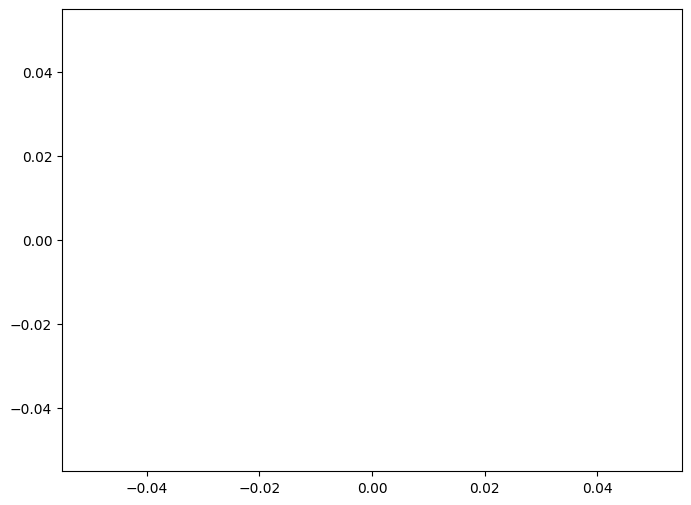

In [ ]:
# 검증 결과 레포트 생성
generate_similarity_report(similarity_df, threshold=0.7)

# KoBert

In [ ]:
import os
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [ ]:
# KoBERT 모델 및 토크나이저 로드
model_name = "monologg/kobert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
embedding_idx = 0 # 1000개 임베딩에 약 5~6분 소요 2000개:11분9초 // 4500개 약 30분
def get_embedding(text):
    """ 주어진 텍스트에 대한 임베딩 벡터를 반환 """
    global embedding_idx
    embedding_idx+=1
    if embedding_idx % 50 == 0:
      print("현재 진행상황:", embedding_idx)
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# 모든 행에 대한 임베딩 생성
df['bert_embedding'] = df['combined_text'].apply(get_embedding)

KeyboardInterrupt: ignored

In [ ]:
# 제거할 컬럼 목록
columns_to_drop = ['embedding']

# 해당 컬럼을 제외한 DataFrame 생성
df_filtered = df.drop(columns=columns_to_drop)

# 결과를 CSV 파일로 저장
df_filtered.to_csv("/content/drive/MyDrive/인지프/특허Dataset/Training_csv/bert_ipc_section_D_embedding_data.csv", index=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_rows(df, target_row_index, num_similar_rows=10):
    """특정 행과 유사한 상위 N개의 행을 반환합니다."""

    # 선택한 행의 임베딩 벡터 가져오기
    selected_row_embedding = df.loc[target_row_index, 'bert_embedding']

    # 유사도 계산
    similarities = df['bert_embedding'].apply(lambda emb: cosine_similarity(selected_row_embedding, emb))

    # 유사도에 따라 데이터 정렬 및 상위 N개 선택
    top_similar_indices = similarities.argsort()[::-1][1:(num_similar_rows+1)]
    top_similar_rows = df.loc[top_similar_indices]

    return top_similar_rows

In [ ]:
# 각 임베딩을 1차원 배열로 변환
# 여기서는 각 임베딩의 평균을 취함.
embeddings = np.array([emb.mean(axis=0) for emb in df['bert_embedding']])

# 유사도 행렬 생성
similarity_matrix = cosine_similarity(embeddings)

# 유사도 행렬을 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,4545,4546,4547,4548,4549,4550,4551,4552,4553,4554
0,1.000000,0.930249,0.921436,0.923614,0.936193,0.944885,0.915875,0.927403,0.965351,0.946931,...,0.860781,0.935627,0.937734,0.931074,0.919797,0.959830,0.959588,0.940495,0.900247,0.902330
1,0.930249,1.000000,0.916560,0.839131,0.930735,0.924245,0.921075,0.913549,0.904545,0.910223,...,0.885243,0.907998,0.921617,0.942077,0.876105,0.916902,0.932806,0.856095,0.927027,0.889350
2,0.921436,0.916560,1.000000,0.870313,0.914245,0.938646,0.886664,0.889998,0.899682,0.932534,...,0.880420,0.927666,0.922288,0.932467,0.878657,0.933005,0.962144,0.899366,0.954402,0.890621
3,0.923614,0.839131,0.870313,1.000000,0.846560,0.878980,0.834530,0.829808,0.960300,0.960939,...,0.775126,0.863201,0.865779,0.849912,0.865182,0.925469,0.913915,0.980786,0.813116,0.859433
4,0.936193,0.930735,0.914245,0.846560,1.000000,0.927263,0.949476,0.945135,0.911192,0.896524,...,0.867569,0.937040,0.947290,0.943159,0.922358,0.927068,0.921989,0.856721,0.927250,0.909912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,0.959830,0.916902,0.933005,0.925469,0.927068,0.973180,0.888644,0.931591,0.970241,0.975251,...,0.842302,0.916246,0.907094,0.909362,0.912860,1.000000,0.946864,0.926968,0.910527,0.904588
4551,0.959588,0.932806,0.962144,0.913915,0.921989,0.937655,0.906757,0.899662,0.941956,0.952154,...,0.910723,0.948051,0.945793,0.943552,0.899366,0.946864,1.000000,0.944652,0.928076,0.901523
4552,0.940495,0.856095,0.899366,0.980786,0.856721,0.895643,0.843333,0.836399,0.955290,0.957926,...,0.805034,0.894311,0.887080,0.877344,0.878528,0.926968,0.944652,1.000000,0.840506,0.875695
4553,0.900247,0.927027,0.954402,0.813116,0.927250,0.922198,0.879577,0.896839,0.863414,0.892450,...,0.861926,0.895365,0.893081,0.924409,0.843756,0.910527,0.928076,0.840506,1.000000,0.853374


In [ ]:
# CSV 파일로 저장
similarity_df.to_csv("/content/drive/MyDrive/인지프/특허Dataset/Training_csv/kobert_ipc_section_D_similarity_df.csv", index=False)

# 유사도 추출 결과 예시 (kobert)

In [ ]:
df[:1]

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding,bert_embedding
0,D06M,합성 섬유 또는 섬유제품의 개질 방법과 그 장치,D,D06M,독립행정법인 산업기술총합 연구소,D06P D06M,D06,탄소 조사 디컬 결합 이중 화합물 원자로 섬유 흡인 성기,D06M 합성 섬유 또는 섬유제품의 개질 방법과 그 장치 D D06M 독립행정법인 ...,"[[0.1560419, -0.099179395, -0.505684, -0.20480...","[[0.004460156, 0.015217062, 0.3876475, -5.8793..."


In [ ]:
# 특정 행 (예: index 0)과 유사한 상위 10개 행 찾기
similar_rows = find_similar_rows(df, target_row_index=0, num_similar_rows=10)

# 결과 출력
similar_rows

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding,bert_embedding
4043,D01G,탄소 섬유 재활용 장치,D,D01G,유에이치티 유니테크 컴퍼니 리미티드,B09B D01G,D01,탄소 마이크로파 재활용 폴리머 섬유 복합 공동 대부분 실제 매트릭스,D01G 탄소 섬유 재활용 장치 D D01G 유에이치티 유니테크 컴퍼니 리미티드 B...,"[[0.01191175, -0.05570025, -0.50662637, -0.312...","[[0.12545738, 0.01653232, 0.326601, -5.412601,..."
2284,D03D,인피섬유 혼합방적사를 사용한 자카드 레노 직물,D,D03D,건양대학교산학협력단,D03D,D03,인피 직물 카드 방적 구조 부여 혼합 신제품 불안 취약점,D03D 인피섬유 혼합방적사를 사용한 자카드 레노 직물 D D03D 건양대학교산학협...,"[[-0.009248855, 0.033314176, -0.465676, -0.281...","[[0.01959793, -0.0121025285, 0.29399458, -5.54..."
4046,D01F,꼬임 구조 탄소나노튜브 섬유의 제조 장치,D,D01F,주식회사 제이오,D01F D02G D02J,D01,나노튜브 탄소 꼬임 권취시킬 지면 구조 감기 강성 획득 섬유,D01F 꼬임 구조 탄소나노튜브 섬유의 제조 장치 D D01F 주식회사 제이오 D0...,"[[0.120091245, -0.048938908, -0.42438006, -0.2...","[[0.04058866, 0.04790515, 0.3481249, -5.444484..."
3456,D01F,비혼화성 중합체 배합물로부터 형성된 섬유,D,D01F,다우 글로벌 테크놀로지스 엘엘씨,D01F,D01,혼합물 감촉 내지 섬유 가소성 체계 비혼 비결정 중합체 폴리스티렌,D01F 비혼화성 중합체 배합물로부터 형성된 섬유 D D01F 다우 글로벌 테크놀로...,"[[0.18188426, -0.014857074, -0.45223352, -0.22...","[[0.060513623, -0.038716875, 0.3261787, -5.282..."
45,D06F,드럼세탁기의 스파이더 구조,D,D06F,엘지전자 주식회사,D06F,D06,드럼 스파이더 정부 드럼세탁기 체결 고정 후벽부 드로잉 보강 회전력,D06F 드럼세탁기의 스파이더 구조 D D06F 엘지전자 주식회사 D06F D06 ...,"[[0.17641243, -0.18954982, -0.41284305, -0.305...","[[0.06740285, 0.019738792, 0.36684626, -5.6676..."
1173,D06P,천연염색 열처리 장치,D,D06P,허호,D06P D06B,D06,스팀 적재 본체 승강 향면 대가 체내 접힌 사부 내부,D06P 천연염색 열처리 장치 D D06P 허호 D06P D06B D06 스팀 적재...,"[[0.22430615, 0.007828797, -0.5410922, -0.2566...","[[0.08583131, 0.049772188, 0.35968354, -5.8494..."
4037,D04H,금속도금 탄소섬유가 첨가된 탄소섬유 부직포 제조방법,D,D04H,재단법인 한국탄소산업진흥원,D04H D01F H05B B01D,D04,탄소섬유 도금 금속 투입 단계 증점제 고분자 필터 교반 용액,D04H 금속도금 탄소섬유가 첨가된 탄소섬유 부직포 제조방법 D D04H 재단법인 ...,"[[0.1819005, 0.039401203, -0.5000311, -0.25159...","[[0.011320506, -0.04617571, 0.37722805, -5.350..."
582,D06H,레이저를 이용한 섬유 가공 장치,D,D06H,노성식,D06H,D06,레이저 후드 상부 공물 테이블 상기 장치 출구 설치 발생,D06H 레이저를 이용한 섬유 가공 장치 D D06H 노성식 D06H D06 레이저...,"[[0.28478914, -0.06980664, -0.4448551, -0.2616...","[[0.05936411, 0.011879837, 0.31382063, -5.5587..."
36,D06F,드럼세탁기의 터브 구조,D,D06F,엘지전자 주식회사,D06F,D06,터브 체결 베어링 드럼세탁기 스테이 구조 접촉 결합부 후방 부와,D06F 드럼세탁기의 터브 구조 D D06F 엘지전자 주식회사 D06F D06 터브...,"[[0.272353, -0.15649165, -0.41319296, -0.27746...","[[0.020335974, 0.047677603, 0.35160515, -5.753..."
3344,D04B,편직기를 위한 장치,D,D04B,그로츠-베케르트 카게,D04B,D04,후크 컨트롤 트랜스 풋트 바늘 슬롯 스티치 레버 아래 단부,D04B 편직기를 위한 장치 D D04B 그로츠-베케르트 카게 D04B D04 후크...,"[[0.059736967, 0.074436456, -0.5543987, -0.248...","[[0.09318627, 0.02230257, 0.2733953, -5.858383..."


In [ ]:
df[3718:3719]

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding,bert_embedding
3718,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25...","[[0.14918174, 0.07648476, 0.45522335, -5.32237..."


In [ ]:
# 특정 행 (예: index 0)과 유사한 상위 10개 행 찾기
similar_rows = find_similar_rows(df, target_row_index=3718, num_similar_rows=10)

# 결과 출력
similar_rows

,ipc_main,invention_title,ipc_section,ipc_subclass,applicant_name,ipc_all,ipc_class,top_keywords,combined_text,embedding,bert_embedding
2684,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25...","[[0.14918174, 0.07648476, 0.45522335, -5.32237..."
3718,D03D,"현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법",D,D03D,한국세라믹기술원,D01F D03D,D03,소스 테이프 상기 단계 섬유 제공 레딩 스프 가소성 성제,"D03D 현무암 섬유를 포함하는 직물 복합재, 및 그 제조 방법 D D03D 한국세...","[[0.07910205, -0.017321795, -0.51711625, -0.25...","[[0.14918174, 0.07648476, 0.45522335, -5.32237..."
3335,D01F,"분기상 기상합성 탄소섬유, 투명 도전성 조성물 및 그 용도",D,D01F,쇼와 덴코 가부시키가이샤,D01F,D01,투명 비저항 탄소섬유 이하 도전 압축 종횡비 외경 기상 함유,"D01F 분기상 기상합성 탄소섬유, 투명 도전성 조성물 및 그 용도 D D01F 쇼...","[[0.06918445, -0.011072515, -0.5211316, -0.254...","[[0.12258857, 0.110197, 0.49530423, -5.2613273..."
2110,D01F,"알루미나질 섬유 집합체, 그 제조 방법 및 용도",D,D01F,덴카 주식회사,D04H D01F C08K,D01,개수 알루미나 섬유 집합 초과 세라믹스 금속 전자현미경 열전도율 길이,"D01F 알루미나질 섬유 집합체, 그 제조 방법 및 용도 D D01F 덴카 주식회사...","[[0.066005245, -0.06026642, -0.48753512, -0.27...","[[0.10053751, 0.038646262, 0.4467468, -5.27140..."
3117,D04H,"섬유 결합체를 성형하는 방법, 그 방법에 의해 성형된 섬유결합체 및 섬유결합체 성형장치",D,D04H,캐논 가부시끼가이샤,D04H,D04,블록 가열 부상 압축 섬유 냉각 공기 결합체 서로 부분,"D04H 섬유 결합체를 성형하는 방법, 그 방법에 의해 성형된 섬유결합체 및 섬유결...","[[0.3615012, -0.038549386, -0.45525938, -0.207...","[[0.11551781, 0.053284667, 0.48323143, -5.1496..."
1874,D03D,"섬유 보강 고분자 스트립, 그 제조방법 및 이를 이용한지오그리드",D,D03D,주식회사 삼양홀딩스,E02D D03D,D03,스트립 발포 보강 고분자 매트릭스 그리드 기공 집합 섬유 미세,"D03D 섬유 보강 고분자 스트립, 그 제조방법 및 이를 이용한지오그리드 D D03...","[[0.18679193, -0.036216702, -0.45773014, -0.26...","[[0.09032133, 0.045098554, 0.4837663, -5.38023..."
2029,D01F,폐폴리에스테르를 이용한 재생 폴리에스테르 단섬유 및 그 제조방법,D,D01F,도레이케미칼 주식회사,D01F D01D,D01,폴리에스테르 재생 열처리 히드록시에틸 권축 해중 단계 섬유 비스 상기,D01F 폐폴리에스테르를 이용한 재생 폴리에스테르 단섬유 및 그 제조방법 D D01...,"[[0.12433622, -0.025298413, -0.47429392, -0.22...","[[0.109204836, 0.056071598, 0.4312503, -5.0892..."
1346,D21H,비목재 펄프와 식물성 섬유를 이용한 비목재 종이 및 그 제조방법,D,D21H,주식회사 지씨티엔,D21H,D21,목재 펄프 식물성 단계 분리 종이 섬유소 혼합물 적당량 물속,D21H 비목재 펄프와 식물성 섬유를 이용한 비목재 종이 및 그 제조방법 D D21...,"[[0.19745797, -0.0909484, -0.43450987, -0.2486...","[[0.12598483, 0.09810374, 0.46127573, -5.22424..."
4497,D21H,비목재 펄프와 식물성 섬유를 이용한 비목재 종이 및 그 제조방법,D,D21H,주식회사 지씨티엔,D21H,D21,목재 펄프 식물성 단계 분리 종이 섬유소 혼합물 적당량 물속,D21H 비목재 펄프와 식물성 섬유를 이용한 비목재 종이 및 그 제조방법 D D21...,"[[0.19745797, -0.0909484, -0.43450987, -0.2486...","[[0.12598483, 0.09810374, 0.46127573, -5.22424..."
2249,D01D,태섬도 고중공사의 초고속 방사 구금 장치 및 그 제조방법,D,D01D,도레이케미칼 주식회사,D01F D01D,D01,중공 태섬 구금 방사 사의 길이 모노 고속 슬릿수 슬릿간,D01D 태섬도 고중공사의 초고속 방사 구금 장치 및 그 제조방법 D D01D 도레...,"[[0.13030896, -0.08058384, -0.5034744, -0.2137...","[[0.1116124, 0.06380677, 0.4080354, -5.318329,..."
